# Packing and influence on cell motility

Some time ago Hadrien Mary [@Hadim_](https://twitter.com/Hadim_) asked me if tyssue could reproduce this work:

<blockquote class="twitter-tweet" data-lang="fr"><p lang="en" dir="ltr">The subtle mechanics of densely packed cells may help explain why some cancerous tumors stay put while others spread <a href="https://t.co/G6lbhLhQxQ">https://t.co/G6lbhLhQxQ</a> <a href="https://t.co/AK9SzzUazU">pic.twitter.com/AK9SzzUazU</a></p>&mdash; Quanta Magazine (@QuantaMagazine) <a href="https://twitter.com/QuantaMagazine/status/907371443025039361?ref_src=twsrc%5Etfw">11 septembre 2017</a></blockquote>
<script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>



![Cellular traffic jam](../data/gif/cellular_traffic_jam.gif)

Illustration is from [Lucy Reading](https://www.lucyreading.co.uk/) [@LucyIkkanda](https://twitter.com/LucyIkkanda)

The relevant model is described in [Mapeng Bi et al.](https://arxiv.org/abs/1409.0593v4) ([nature physics version ($$)](https://www.nature.com/articles/nphys3471))

The master equation is the following:

$$\epsilon = \sum_\alpha \left[ (a_\alpha - 1)^2 + \frac{(p_\alpha - p_0)^2}{r}\right]$$

With a unit prefered area and $p_\alpha$ the cell perimeter.

### Imports

In [1]:
import numpy as np
import pandas as pd

from tyssue import config, Sheet, PlanarGeometry
from tyssue.solvers import QSSolver

from tyssue.solvers.viscous import EulerSolver
from tyssue.draw import sheet_view

from tyssue.dynamics.factory import model_factory
from tyssue.dynamics import effectors, units
from tyssue.utils import to_nd
from tyssue.utils.testing import effector_tester, model_tester
from tyssue.behaviors import EventManager
from tyssue.behaviors.sheet import basic_events

from tyssue.draw import highlight_faces, create_gif

### Create a 2D patch of cells

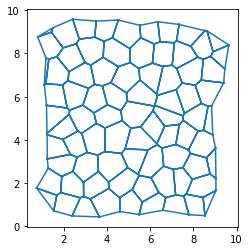

In [2]:
geom = PlanarGeometry

sheet = Sheet.planar_sheet_2d('jam', 15, 15, 1, 1, noise=0.2)
geom.update_all(sheet)

sheet.remove(sheet.cut_out([[0, 10], [0, 10]]), trim_borders=True)
sheet.sanitize()
geom.scale(sheet, sheet.face_df.area.mean()**-0.5, ['x', 'y'])
geom.update_all(sheet)
sheet.reset_index()
sheet.reset_topo()
fig, ax = sheet_view(sheet, mode="quick")

### Define the relevant mechanical components 

array([[nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan]])

In [73]:

# From Mapeng Bi et al. https://doi.org/10.1038/nphys3471
class PermiterElasticity(effectors.AbstractEffector):
    
    dimensions = units.line_elasticity
    magnitude = 'perimeter_elasticity'
    label = 'Perimeter Elasticity'
    element = 'face'
    specs = {
        'face': {
            'is_alive': 1,
            'perimeter': 1.0,
            'perimeter_elasticity': 0.1,
            'prefered_perimeter': 1.0
            }
        }

    spatial_ref = 'prefered_perimeter', units.length

    @staticmethod
    def energy(eptm):
        return eptm.face_df.eval('0.5 * is_alive'
                                 '* perimeter_elasticity'
                                 '* (perimeter - prefered_perimeter)** 2')

    @staticmethod
    def gradient(eptm):

        gamma_ = eptm.face_df.eval(
            'perimeter_elasticity * is_alive'
            '*  (perimeter - prefered_perimeter)')
        gamma = eptm.upcast_face(gamma_)

        grad_srce = - eptm.edge_df[eptm.ucoords] * to_nd(gamma,
                                                         len(eptm.coords))
        grad_srce.columns = ['g'+u for u in eptm.coords]
        grad_trgt = - grad_srce
        return grad_srce, grad_trgt


    
    
# A simple effector to pull a cell
class FaceTraction(effectors.AbstractEffector):
    
    dimensions = units.line_tension
    magnitude = 'traction_x'
    label = 'Cell Traction'
    element = 'face'
    specs = {
        'face': {
            'is_alive': 1,
            'traction_x': -1.0,
            'traction_y': 1.0,
            'traction_z': 0.0,
        }
    }
    
    @staticmethod
    def energy(eptm):
        return np.zeros(eptm.Ne)
        
    @staticmethod
    def gradient(eptm):
        
        r_ai = (eptm.edge_df[['f'+c for c in eptm.coords]].values
                - eptm.edge_df[['s'+c for c in eptm.coords]].values)
        r_aj = (eptm.edge_df[['f'+c for c in eptm.coords]].values 
                - eptm.edge_df[['t'+c for c in eptm.coords]].values)
        
        force = eptm.upcast_face(eptm.face_df[["traction_"+c for c in eptm.coords]]).values
        grad_srce = pd.DataFrame(
            data=-force,
            index=eptm.edge_df.index,
            columns=['g'+c for c in eptm.coords])
        
        grad_trgt = pd.DataFrame(
            data=-force,
            index=eptm.edge_df.index,
            columns=['g'+c for c in eptm.coords])
        return grad_srce, grad_trgt
    
# Adding some gigling
class BrownianMotion(effectors.AbstractEffector):
    
    label = 'Brownian Motion'
    element = 'vert'
    specs = {"settings": {"temperature": 1e-3}}
    
    def energy(eptm):
        T = eptm.settings['temperature']
        return np.ones(eptm.Nv) * T / eptm.Nv
    
    def gradient(eptm):
        T = eptm.settings['temperature']
        scale = T/eptm.edge_df.length.mean()
        
        grad = pd.DataFrame(
            data=np.random.normal(0, scale=scale, size=(eptm.Nv, eptm.dim)),
            index=eptm.vert_df.index,
            columns=['g'+c for c in eptm.coords]
        )
        return grad, None
    
    

model_specs = {
    'face': {
        'area_elasticity': 1.,
        'prefered_area': 1.,
        'perimeter_elasticity': 0.1, # 1/2r in the master equation
        'prefered_perimeter': 3.81,
        },
    'edge': {
        'ux': 0,
        'uy': 0,
        'is_active': 1,
        'line_tension': 0.0
    },
    'settings': {'temperature': 1e-2}
}
    
sheet.update_specs(model_specs, reset=True)

Reseting column area_elasticity of the face dataset with new specs
Reseting column prefered_area of the face dataset with new specs
Reseting column perimeter_elasticity of the face dataset with new specs
Reseting column prefered_perimeter of the face dataset with new specs
Reseting column traction_x of the face dataset with new specs
Reseting column traction_y of the face dataset with new specs
Reseting column ux of the edge dataset with new specs
Reseting column uy of the edge dataset with new specs
Reseting column is_active of the edge dataset with new specs
Reseting column line_tension of the edge dataset with new specs


### Quasistatic gradient descent

With only the conservative potential terms

In [74]:

model = model_factory(
    [PermiterElasticity,
     effectors.LineTension,
     effectors.FaceAreaElasticity])

res = QSSolver().find_energy_min(sheet, PlanarGeometry, model)

print(res.message)

b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Backup so we can play with parameters

In [75]:
bck = sheet.copy()

## Pulling on a face

Chosen with trial and error

In [111]:
eptm = sheet
face = 4
axis = np.array([0.1, 0.5])

    
def tract(eptm, face, pull_axis, value, pull_column='line_tension', face_id=None):
    pull_axis = np.asarray(pull_axis)
    edges = eptm.edge_df.query(f'face == {face}')
    verts = edges['srce'].values
    r_ai = (
        edges[["s"+c for c in eptm.coords]].values
        - edges[["f"+c for c in eptm.coords]].values
    )
    proj = (r_ai * pull_axis[None, :]).sum(axis=1)
    pulling_vert = verts[np.argmax(proj)]

    v_edges = eptm.edge_df.query(
        f'(srce == {pulling_vert}) & (face != {face})'
    )
    try:
        pulling_edge = v_edges[~v_edges['trgt'].isin(edges['srce'])].index[0]
        eptm.edge_df.loc[pulling_edge, pull_column] = value
    except IndexError:
        pulling_edge = -1
    
    return pulling_edge
    
default_traction_spec = {
    "face": -1,
    "face_id": -1,
    "pull_axis": [0.7, 0.7],
    "value": 4,
    "pull_column": "line_tension"
}


from tyssue.utils.decorators import face_lookup

@face_lookup
def traction(sheet, manager, **kwargs):
    
    traction_spec = default_traction_spec
    traction_spec.update(**kwargs)
    pulling = tract(sheet, **traction_spec)
    
    if pulling != -1:
        manager.append(traction, **traction_spec)


In [112]:
pulled = 28

#### Simple visualisation

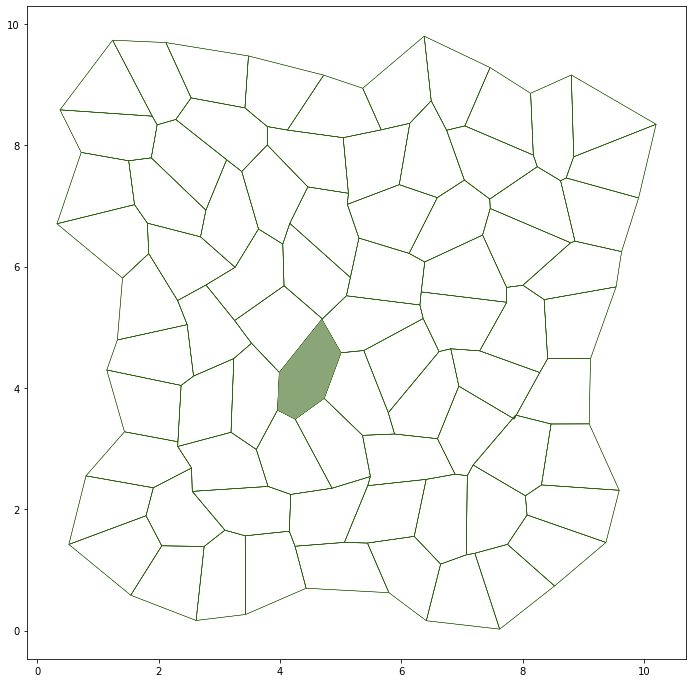

In [113]:
highlight_faces(sheet.face_df, [pulled,], reset_visible=True)
fig, ax = sheet_view(
    sheet, 
    mode="2D", 
    face={"visible": True},
    edge={"head_width": 0.0}, 
    vert={"visible": False})
fig.set_size_inches(12, 12)

####  Model with all the components

In [114]:
model = model_factory(
    [PermiterElasticity,
     BrownianMotion,
     effectors.LineTension,
     effectors.FaceAreaElasticity])

In [137]:
sheet = bck.copy()


# setting up values for the whole epithelium
model_specs = {
    'face': {
        'area_elasticity': 1.,
        'prefered_area': 1.,
        'perimeter_elasticity': 0.1, # 1/2r in the master equation
        'prefered_perimeter': 3.81,
        "id": sheet.face_df.index
        },
    'vert': {
        "viscosity": 1.0
        },
    'edge': {'ux': 0, 'uy': 0},
    'settings': {'temperature': 1e-1, "p_4": 10.0, "p_5p": 1.0}
}

sheet.update_specs(model_specs, reset=True)

# This allows to auomaticaly solve topology changes

manager = EventManager("face", )
manager.append(basic_events.reconnect)
manager.append(traction, face_id=pulled)

# Implicit Euler solver

solver = EulerSolver(
    sheet,
    geom,
    model,
    manager=manager,
    bounds=(
        -sheet.edge_df.length.median()/10,
        sheet.edge_df.length.median()/10
    )
)
manager.update()


sheet.face_df['prefered_perimeter'] = 3.8

Reseting column area_elasticity of the face dataset with new specs
Reseting column prefered_area of the face dataset with new specs
Reseting column perimeter_elasticity of the face dataset with new specs
Reseting column prefered_perimeter of the face dataset with new specs
Reseting column id of the face dataset with new specs
Reseting column viscosity of the vert dataset with new specs
Reseting column ux of the edge dataset with new specs
Reseting column uy of the edge dataset with new specs


### Run the solver

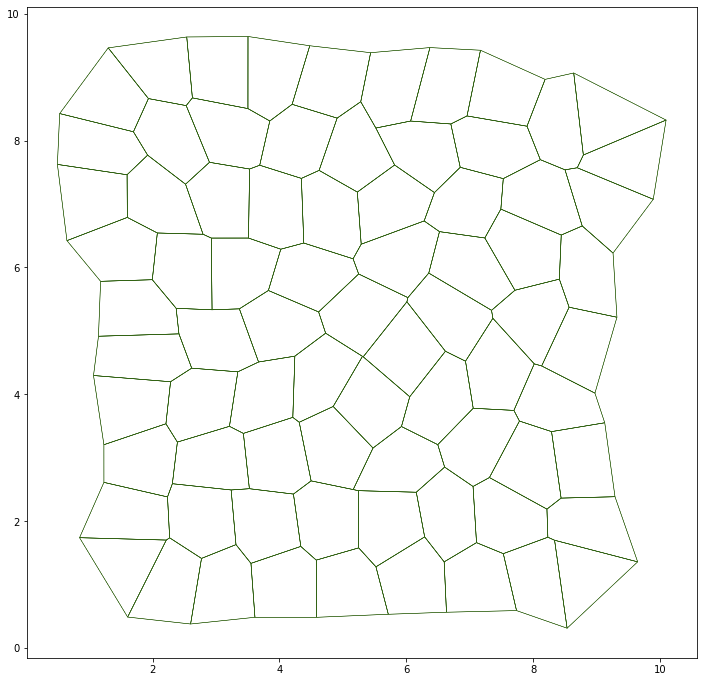

In [138]:
def reset_lt(eptm):
    eptm.edge_df['line_tension'] = 0.0
    
solver.solve(tf=240.0, dt=0.1, on_topo_change=reset_lt, topo_change_args=(sheet,))

fig, ax = sheet_view(
    sheet,
    mode="2D",
    face={"visible": False},
    edge={"head_width": 0.0},
    vert={"visible": False}
)
fig.set_size_inches(12, 12)

### Define a simple function

In [142]:
def view(sheet):
    highlight_faces(sheet.face_df, [pulled], reset_visible=True)
    geom.update_all(sheet)
    fig, ax = sheet_view(
        sheet,
        mode="2D",
        face={"visible": True},
        edge={"head_width": 0.0, "color": sheet.edge_df['line_tension']},
        vert={"visible": False}
    )
    fig.set_size_inches(12, 12)
    return fig, ax

In [143]:
# Cerate a gif of the resulting simulation
create_gif(solver.history, "non_rigid.gif", draw_func=view)

/home/guillaume/miniconda3/envs/tyssue/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/guillaume/miniconda3/envs/tyssue/lib/python3.7/site-packages/tyssue-0.5.0-py3.7-linux-x86_64.egg/tyssue/draw/plt_draw.py:313: UserWarning: Attempting to draw a colormap with a uniform value
  warnings.warn("Attempting to draw a colormap " "with a uniform value")


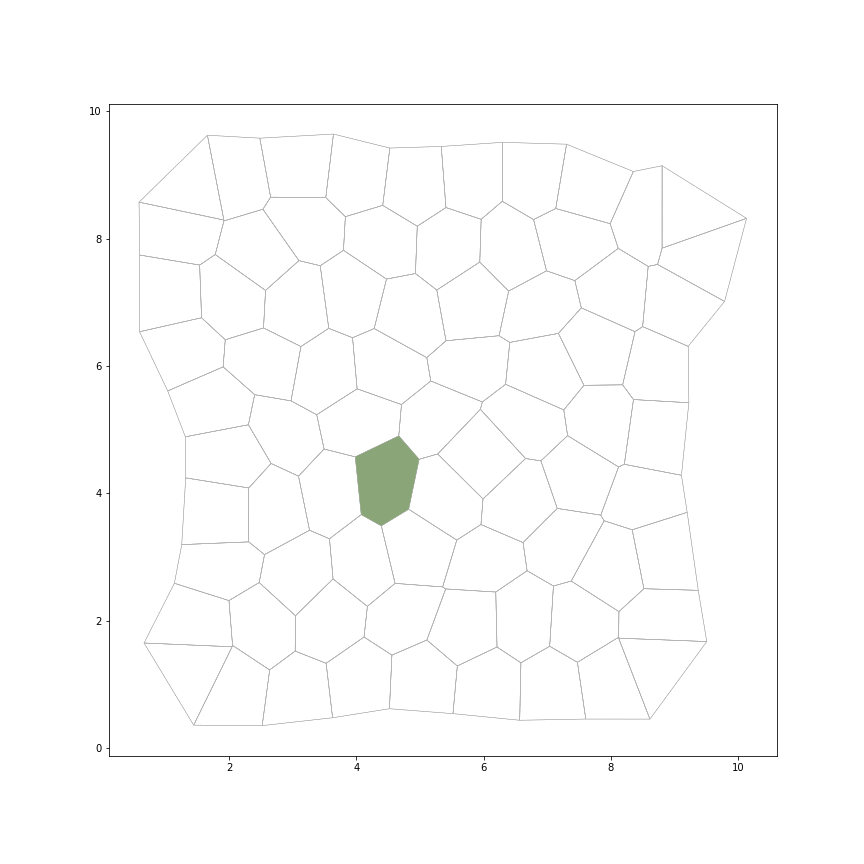

In [144]:
from IPython.display import Image
Image("non_rigid.gif")

![](test_rigid.gif)